In [2]:
import numpy as np
import matplotlib.pyplot as plt
from EDMtools import *
from SampTrajsTools import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
dim = 2 #dimension
n_anchors = 5 #number of anchors
n_positions = 20 #number of robot sample positions
n_complexity = 4 #model complexity

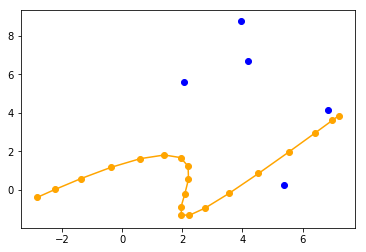

In [4]:
np.random.seed(1)
coeffs = 5 * np.random.rand(dim, n_complexity)
anchors = 10 * np.random.rand(dim, n_anchors)


k=np.reshape(range(n_complexity), [n_complexity, 1])
n=np.reshape(range(n_positions), [1, n_positions])
basis = np.cos(np.pi * k * n / n_positions)

trajectory = coeffs @ basis

#continuous trajectory for plotting
n_cont=np.reshape(np.linspace(0, n_positions, 1000), [1, 1000])
basis_cont = np.cos(np.pi * k * n / n_positions)
trajectory_cont = coeffs @ basis_cont

plt.scatter(*anchors, color='blue')
plt.scatter(*trajectory,color='orange')
plt.plot(*trajectory_cont, color='orange')
#plt.axis('off')
#plt.savefig('traj_setup.png')

In [5]:
#EDM stuff
X = np.hstack([trajectory,anchors])
G = X.T @ X
D = np.outer(np.ones(n_positions + n_anchors),np.diag(G))+np.outer(np.diag(G),np.ones(n_positions+n_anchors))-2*G

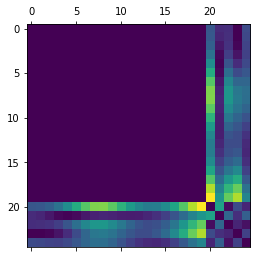

In [6]:
D_tilde = D.copy()
D_tilde[:n_positions,:n_positions] = 0
plt.matshow(D_tilde)
D_topright = D[:n_positions,n_positions:] 

## SDP - based approach
### Noiseless case

In [7]:
print("Make sure that your cvxpy version is >= 1.0.6!")
import cvxpy
print("Your version:", cvxpy.__version__)

from SampTrajsTools import OPTIONS

# We cane change the global variable OPTIONS here. 

#OPTIONS[cvxpy.SCS]["max_iters"] = 200
# Seems to have no effect: 
#OPTIONS[cvxpy.SCS]["use_indirect"] = False 
# Seems to have no effect either: 
#OPTIONS[cvxpy.SCS]["eps"] = 1e-1
# Seems to have no effect either: 
#OPTIONS[cvxpy.SCS]["scale"] = 1


# Fails completely without this:
OPTIONS[cvxpy.CVXOPT]["kktsolver"] = "robust"

# have no effect:
OPTIONS[cvxpy.CVXOPT]["feastol"] = 1e-1
OPTIONS[cvxpy.CVXOPT]["reltol"] = 1e-1
OPTIONS[cvxpy.CVXOPT]["abstol"] = 1e-1

# leads to faster non-convergence: 
OPTIONS[cvxpy.CVXOPT]["refinement"] = 0


X = semidefRelaxationNoiseless(D_topright, anchors, basis, cvxpy.CVXOPT)
#X = semidefRelaxation(D_topright, anchors, basis)

Make sure that your cvxpy version is >= 1.0.6!
Your version: 1.0.6
Running with options: {'max_iters': 100, 'abstol': 0.1, 'reltol': 0.1, 'feastol': 0.1, 'refinement': 0, 'kktsolver': 'robust'}
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  4e+01  7e+00  3e+00  1e+00
 1: -7.2253e+08  2.8422e-01  9e+00  2e+00  1e+00  6e-01
Certificate of dual infeasibility found.


### Debugging - Start

In [8]:
#check the correct trajectory satisfies constraints
Z_opt = np.vstack([np.hstack([np.eye(2),coeffs]),np.hstack([coeffs.T,coeffs.T@coeffs])])

for d in range(dim):
    e_d = np.zeros((dim + n_complexity, 1))
    e_d[d] = 1.0
    for dprime in range(dim):
        e_dprime = np.zeros((dim + n_complexity, 1))
        e_dprime[dprime] = 1.0
        
        delta = 1.0 if d == dprime else 0.0
        
        print(e_d.T @ Z_opt @ e_dprime == delta)


W = D_topright > 0
Ns, Ms = np.where(W)

for i, (m, n) in enumerate(zip(Ms, Ns)):
    e_n = np.zeros((n_positions, 1))
    e_n[n] = 1.0
    a_m = np.reshape(anchors[:, m], (-1, 1))
    t_mn = np.r_[a_m, -basis @ e_n]
    
    print(np.isclose(t_mn.T @ Z_opt @ t_mn, D_topright[n ,m]))

[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]


In [9]:
#check the correct trajectory is PSD
w, v = np.linalg.eig(Z_opt)
print(w)

[ 2.25887071e+01 -3.94649591e-16  3.62000582e+00  6.82184491e-16
 -4.97461246e-16 -8.56312041e-17]


In [10]:
#check that we have enough independant constraints. Think we need (K+D)*(K+D+1)/2-(D*(D+1)/2)=K(K+1)/2+DK=18
TmnStack = []
for i, (m, n) in enumerate(zip(Ms, Ns)):
    e_n = np.zeros((n_positions, 1))
    e_n[n] = 1.0
    a_m = np.reshape(anchors[:, m], (-1, 1))
    t_mn = np.r_[a_m, -basis @ e_n]
    Tmn=t_mn@t_mn.T
    TmnStack.append(Tmn.flatten())
TmnStack=np.array(TmnStack)
print(TmnStack.shape)
u, s, vh = np.linalg.svd(TmnStack)
print(s)

(100, 36)
[5.77430570e+02 2.23768204e+02 7.65158639e+01 7.14969439e+01
 6.62508022e+01 5.79070065e+01 2.78316373e+01 2.60811111e+01
 2.41142889e+01 1.43917281e+01 6.19773693e+00 5.02580453e+00
 4.49165628e+00 3.43566667e+00 2.68436363e+00 2.27678206e+00
 2.14938373e+00 4.04596575e-14 4.04596575e-14 4.04596575e-14
 4.04596575e-14 4.04596575e-14 4.04596575e-14 4.04596575e-14
 4.04596575e-14 4.04596575e-14 4.04596575e-14 4.04596575e-14
 4.04596575e-14 4.04596575e-14 4.04596575e-14 4.04596575e-14
 4.04596575e-14 4.04596575e-14 4.04596575e-14 3.07366156e-15]


## Investigate null space

In [52]:
#Write all constraints as a matrix vector product

ConstraintsMat = []
ConstraintsVec = []

#constraints for identity submatrix
for d in range(dim):
    e_d = np.zeros((dim + n_complexity, 1))
    e_d[d] = 1.0
    for dprime in range(dim):
        e_dprime = np.zeros((dim + n_complexity, 1))
        e_dprime[dprime] = 1.0
        
        delta = 1.0 if d == dprime else 0.0
        
        tmp = e_dprime@e_d.T
        ConstraintsMat.append(tmp.flatten())
        ConstraintsVec.append(delta)

#constraints for distance measurements
for i, (m, n) in enumerate(zip(Ms, Ns)):
    e_n = np.zeros((n_positions, 1))
    e_n[n] = 1.0
    a_m = np.reshape(anchors[:, m], (-1, 1))
    t_mn = np.r_[a_m, -basis @ e_n]
    tmp=t_mn@t_mn.T
    ConstraintsMat.append(tmp.flatten())
    ConstraintsVec.append(D_topright[n ,m])

#constraints for symmetry
for i in range(dim + n_complexity):
    for j in range(i+1,dim + n_complexity):
        tmp = np.zeros((dim + n_complexity)*(dim + n_complexity))
        tmp[i*(dim + n_complexity)+j]=1
        tmp[j*(dim + n_complexity)+i]=-1
        ConstraintsMat.append(tmp.flatten())
        ConstraintsVec.append(0)

ConstraintsMat=np.array(ConstraintsMat)
ConstraintsVec=np.array(ConstraintsVec)

print(np.isclose(ConstraintsMat@Z_opt.flatten(),ConstraintsVec))

print(ConstraintsMat.shape)
print(ConstraintsVec.shape)
u, s, vh = np.linalg.svd(ConstraintsMat, full_matrices=True)
print(np.around(s,3))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
(119, 36)
(119,)
[5.77431e+02 2.23770e+02 7.65160e+01 7.14970e+01 6.62510e+01 5.79150e+01
 2.78320e+01 2.60810e+01 2.41140e+01 1.43930e+01 6.19800e+00 5.02600e+00
 4.49900e+00 3.43600e+00 2.68400e+00 2.27700e+00 2.14900e+00 1.73200e+00
 1.41400e+00 1.41400e+00 1.41400e+00 1.

In [53]:
#construct right inverse and check meets constraints
num_zero_SVs = len(np.where(s<1e-10)[0])
Z_hat = vh[:-num_zero_SVs,:].T@np.diag(1/s[:-num_zero_SVs])@u[:,:len(s)-num_zero_SVs].T@ConstraintsVec #right inverse
Z_hat = Z_hat.reshape([dim + n_complexity,dim + n_complexity])
print(np.isclose(ConstraintsMat@Z_hat.flatten(),ConstraintsVec)) #should satisfy constraints since it's a right inverse
coeffs_hat = Z_hat[:dim,dim:]
print(np.isclose(coeffs,coeffs_hat))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[[ True  True  True  True]
 [ True  True  True  True]]


In [54]:
tmp = vh[-num_zero_SVs:,:]
print(tmp.shape)
nullSpace = []
for i in range(num_zero_SVs):
    nullSpace.append(tmp[i,:].reshape([dim + n_complexity,dim + n_complexity]))

nullSpace = np.array(nullSpace)
Z_hat2 = Z_hat+nullSpace[0,:]+2*nullSpace[1,:]+3*nullSpace[2,:]
print(np.isclose(ConstraintsMat@(Z_hat2.flatten()),ConstraintsVec))

(3, 36)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


In [55]:
print(np.around(nullSpace[0,:],5))
print(np.around(nullSpace[1,:],5))
print(np.around(nullSpace[2,:],5))

[[ 0.       0.       0.      -0.      -0.      -0.     ]
 [-0.      -0.      -0.      -0.       0.       0.     ]
 [-0.      -0.      -0.21223  0.23083  0.11357  0.23083]
 [-0.      -0.       0.23083 -0.0149  -0.46166 -0.21968]
 [-0.      -0.       0.11357 -0.46166  0.43936 -0.     ]
 [-0.      -0.       0.23083 -0.21968 -0.      -0.     ]]
[[ 0.       0.       0.       0.       0.       0.     ]
 [-0.       0.       0.       0.       0.      -0.     ]
 [-0.       0.      -0.26116 -0.17313  0.16247 -0.17313]
 [-0.      -0.      -0.17313 -0.06379  0.34625 -0.29305]
 [ 0.      -0.       0.16247  0.34625  0.5861  -0.     ]
 [ 0.      -0.      -0.17313 -0.29305  0.      -0.     ]]
[[ 0.       0.      -0.       0.      -0.      -0.     ]
 [-0.      -0.      -0.       0.      -0.       0.     ]
 [-0.      -0.       0.4236   0.00891  0.21464  0.00891]
 [-0.       0.       0.00891 -0.85289 -0.01783 -0.00284]
 [ 0.      -0.       0.21464 -0.01783  0.00568  0.     ]
 [ 0.       0.       0.00891 

### cvxopt

In [97]:
# try linear program
from cvxopt import matrix, solvers
tmpMat=np.diag(s[:-num_zero_SVs])@vh[:-num_zero_SVs,:]
tmpVec = u[:,:len(s)-num_zero_SVs].T@ConstraintsVec
A = matrix(np.vstack([tmpMat,-tmpMat]))
b = matrix(np.hstack([tmpVec,-tmpVec]))
c = matrix(np.ones((dim + n_complexity)*(dim + n_complexity)))
sol=solvers.lp(c,A,b, solver='glpk') #doesn't work eith defualt solver but glpk good
print(sol)
Z_hat = np.array(sol['x']).reshape([dim + n_complexity,dim + n_complexity])
print(np.isclose(Z_hat,Z_opt))

{'status': 'optimal', 'x': <36x1 matrix, tc='d'>, 's': <66x1 matrix, tc='d'>, 'y': <0x1 matrix, tc='d'>, 'z': <66x1 matrix, tc='d'>, 'primal objective': 90.78998261966372, 'dual objective': 90.78998261966372, 'gap': 1.2459768295483948e-14, 'relative gap': 1.3723725829621818e-16, 'primal infeasibility': 1.3428407630744117e-16, 'dual infeasibility': 4.025611124295535e-15, 'primal slack': -7.056857988792678e-13, 'dual slack': -3.4234767798402288e-15, 'residual as primal infeasibility certificate': None, 'residual as dual infeasibility certificate': None}
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True False False False False]
 [ True  True False False False False]
 [ True  True False False False  True]
 [ True  True False False  True  True]]


### Debugging - End

## MDS - based approach
### Noiseless case

In [13]:
# find new coefficients
coeffs_est = customMDS(D_topright, basis, anchors)
print(coeffs_est)
print(coeffs)

[[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]
[[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]


In [ ]:
trajectory_est = coeffs_est @ basis
trajectory_est_cont = coeffs_est @ basis_cont

plt.scatter(*anchors)
plt.scatter(*trajectory, color='orange', label='true')
plt.plot(*trajectory_cont, color='orange')
plt.scatter(*trajectory_est, color = 'red', label='estimated')
plt.plot(*trajectory_est_cont, color='red')
plt.axis('off')

### Noisy case

In [ ]:
sigma = 4

#state = np.random.RandomState(1)
np.random.seed(1)

D_topright_noisy = D_topright + sigma * np.random.randn(*(D_topright.shape))
coeffs_est_noisy = customMDS(D_topright_noisy, basis, anchors)

coeffs_est_noisy, costs = gradientDescent(
    anchors, basis, coeffs_est_noisy, 
    D_topright_noisy,maxIters=50)
#print(checkStationaryPointSRLS(A,F,C_hat,DTR_tilde))
#plt.plot(costs)

In [ ]:
trajectory_est_noisy = coeffs_est_noisy @ basis
trajectory_est_noisy_cont = coeffs_est_noisy @ basis_cont

plt.scatter(*anchors, color='blue')
plt.plot(*trajectory_cont, color='orange')
plt.scatter(*trajectory_est_noisy, color='red')
plt.plot(*trajectory_est_noisy_cont, color='red')

### Missing measurements

missing measurements between anchors, and between anchors and robot

In [ ]:
np.random.seed(1)

sigma = 2
missing_proportion = 0.9

D_right = D[:,n_positions:]
mask = np.ones(D_right.shape)

mask[:n_positions, :] *= (np.random.rand(n_positions,n_anchors)>missing_proportion)
D_right_missing = mask * D_right

# TODO: why are anchor positions not noisy? 
np.random.seed(1)
D_right_missing[:n_positions,:] += sigma * np.random.randn(n_positions, n_anchors)
D_right_est, errs = alternateGDandKEonDR(D_right_missing, mask, basis, anchors, 
                                    niter=40, DR_true=D_right)
plt.plot(errs)
coeffs_est_missing = customMDS(D_right_est[:n_positions,:], basis, anchors)
#print(C_hat)
#print(C)

In [ ]:
trajectory_est_missing = coeffs_est_missing @ basis
trajectory_est_missing_cont = coeffs_est_missing @ basis_cont

plt.scatter(*anchors, color='blue')
#plt.scatter(*trajectory, color='orange')
plt.plot(*trajectory_cont, color='orange')
plt.scatter(*trajectory_est_missing, color='red')
plt.plot(*trajectory_est_missing_cont, color='red')
plt.axis('off')
#plt.savefig('traj_rec_with_noise.png')

In [ ]:
plt.scatter(*anchors, color='blue')
plt.plot(*trajectory_cont, color='orange')
trajectory_useful = trajectory[:,np.any(mask[:n_positions,:]!=0,axis=1)]
plt.scatter(*trajectory_useful, color='orange')
#plt.axis('off')
#plt.savefig('traj_useful.png')

In [ ]:
plt.figure()
plt.scatter(*anchors)
plt.plot(*trajectory_cont, color='orange')
for i in range(n_positions):
    point = trajectory[:, i]
    if np.sum(mask[i,:])==1:
        plt.scatter(*point,color='orange')
    if np.sum(mask[i,:])==2:
        plt.scatter(*point,color='red')
    if np.sum(mask[i,:])>2:
        plt.scatter(*point,color='green')
plt.scatter(-2.8,6)
plt.scatter(-2.8,5,color='orange')
plt.scatter(-2.8,4,color='red')
plt.scatter(-2.8,3,color='green')
#plt.axis('off')
#plt.legend()
#plt.savefig('traj_useful_colorcoded.png')

In [ ]:
D_right_est, errs = alternateGDandKEonDR(D_right_missing, 
                                    mask, basis, anchors, 
                                    niter=30, DR_true=D_right)
plt.plot(errs)
coeffs_est = customMDS(D_right_est[:n_positions,:], basis, anchors)

In [ ]:
trajectory_est = coeffs_est @ basis
trajectory_est_cont = coeffs_est @ basis_cont

plt.scatter(*anchors)
plt.scatter(*trajectory,color='orange')
plt.plot(*trajectory_cont,color='orange')

plt.scatter(*trajectory_est,color='red')
plt.plot(*trajectory_est_cont,color='red')
#plt.axis('off')
#plt.savefig('traj_rec.png')

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
tmp = D_right[:n_positions,:]
print(tmp[mask[:n_positions,:]==1])
print(mask[:n_positions,:]*tmp)

tmp = D_right_missing[:n_positions,:]
print(tmp[mask[:n_positions,:]==1])
print(mask[:n_positions,:]*tmp)